# Noise reducing Work & ML implementation

In [1]:
%matplotlib inline

### Importing all necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Load the data using pandas

In [4]:
df = pd.read_excel(r"028.xlsx")   # loading the reference data
df.head()

,08/05/2020,amplitude,Ver.,3,Rapid Scan,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Optical Delay,530.320000,NaN,Delta X (ps),0.078125,Sweeps,1000.0,Scan Rate,Shaker
1,530.32,-0.000936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,530.398,-0.001682,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,530.476,-0.002000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,530.554,-0.002204,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
f=open("033.txt","r")   # loading the sample data
lines=f.readlines()

# sample data storing
time_sample=[]
voltage_sample = []
for x in lines[2:]:
    time_sample.append(eval(x.split()[0]))
    voltage_sample.append(eval(x.split()[1]))
f.close()

### Data visualisation

Here, we are going to transform the time domain into frequency domain using **Fast Fourier Transform** (fft). 
Mention that, to convert the time to frequency we use **fft** and from frquency to time we use **Inverse Fast Fourier Transform** (ifft).

In [6]:
# Reference Data storing

time_ref = df["08/05/2020"][1:]
voltage_ref = df["amplitude"][1:]

In [7]:
nrows1 = len(time_sample)
nrows2 = len(time_ref)

firstTen1 = voltage_sample[:10]
firstTen2 = voltage_ref[:10]

z1 = sum(firstTen1)
z2 = sum(firstTen2)

offset1 = 0.1 * z1
offset2 = 0.1 * z2

offsetSam_voltage = [i - offset1 for i in voltage_sample]
offsetRef_voltage = voltage_ref - offset2

In [8]:
deltanu = 1 / (time_ref[nrows2] - time_ref[1])
n3thz = int(3/deltanu)

#implement FFT on both reference data and sample data
ampl_ref = abs(fft(offsetRef_voltage.values))
ampl_sam = abs(fft(offsetSam_voltage))

ii = list(range(1,n3thz))
freq = [i * deltanu for i in ii]

### Ploting the data

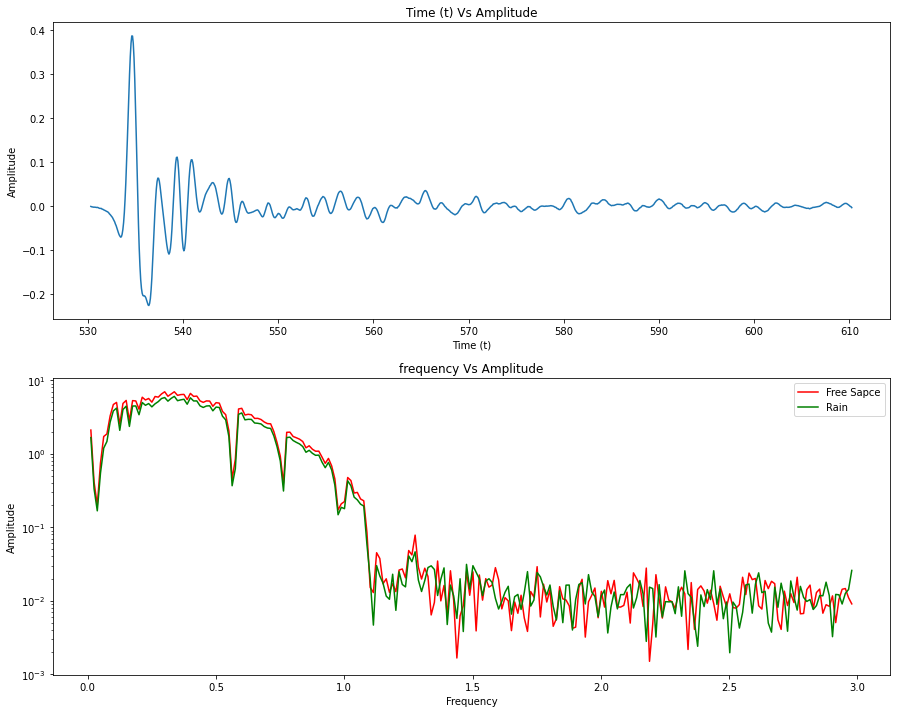

In [9]:
fig = plt.figure(figsize= (15,12))

fig.add_subplot(2, 1, 1)
plt.plot(time_ref, voltage_ref)
plt.title("Time (t) Vs Amplitude")
plt.xlabel("Time (t)")
plt.ylabel("Amplitude")

fig.add_subplot(2, 1, 2)
plt.semilogy(freq, ampl_ref[:len(freq)], "r-")
plt.semilogy(freq, ampl_sam[:len(freq)], "g-")
plt.title("frequency Vs Amplitude")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend(["Free Sapce", "Rain"])

plt.savefig("Noise_graph.png")
plt.show()

### Calculation of Signal Attenuation

In [10]:
signal_attenuation = [abs(ampl_ref[i] - ampl_sam[i]) for i in range(len(freq))]

#### Ploting the Frequency Vs Noise attenuation data

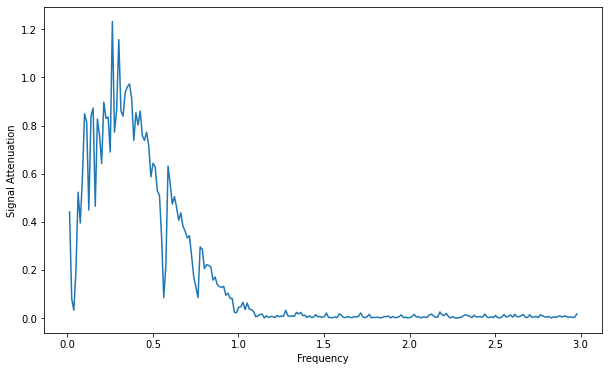

In [11]:
fig = plt.figure(figsize=(10,6))
plt.plot(freq, signal_attenuation)
plt.xlabel("Frequency")
plt.ylabel("Signal Attenuation")
plt.savefig("signal_attenuation.png")

# Machine Learning models

#### Data Processing

In [12]:
from sklearn.model_selection import train_test_split as tts

In [13]:
freq = np.asarray(freq).reshape(-1,1)
signal_attenuation = np.asarray(signal_attenuation).reshape(-1,1)

In [23]:
train_x, test_x, train_y, test_y = tts(freq, signal_attenuation, train_size= 0.85)

## Artificial Neural Network

In [24]:
import tensorflow as tf

In [25]:
from keras import backend as K

In [26]:
model_ANN = tf.keras.Sequential([tf.keras.layers.Dense(units = 4, activation="relu", input_shape=[1]),
                                 tf.keras.layers.Dense(units = 2, activation="relu"),
                                 tf.keras.layers.Dense(units = 1)])

In [27]:
def soft_acc(y, y_pred):
    return K.mean(K.equal(K.round(y), K.round(y_pred)))


model_ANN.compile(loss="mean_absolute_error", optimizer='adam', metrics=[soft_acc])

history = model_ANN.fit(freq, signal_attenuation, verbose = 0, epochs = 20)

In [28]:
_, acc = model_ANN.evaluate(test_x, test_y)
print("The accuracy of validation model {:.2f}%".format(acc * 100))

2/2 [==============================] - 0s 2ms/step - loss: 0.1558 - soft_acc: 0.9219
The accuracy of validation model 92.19%


In [29]:
pred_y_ANN = model_ANN.predict(test_x)

#### Visualisation of the measured accuracy.

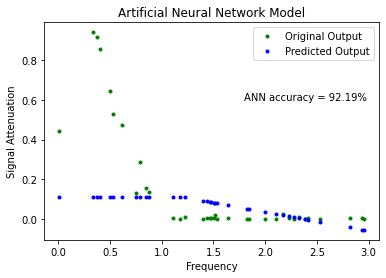

In [30]:
plt.plot(test_x, test_y, 'g.', label='Original Output' )
plt.plot(test_x, pred_y_ANN, 'b.', label= "Predicted Output")
plt.text(1.8, 0.6, ("ANN accuracy = {:0.2f}%".format(100 * acc)))
plt.xlabel('Frequency')
plt.ylabel('Signal Attenuation')
plt.title('Artificial Neural Network Model')
plt.legend()
plt.savefig('prediction_by_ANN.png')

### Visualize a comparison result as a bar graph

In [32]:
df1 = pd.DataFrame({"Actual": test_y.flatten(), 
                    "Predicted": pred_y_ANN.flatten()},
                  index=range(1, len(test_y)+1))
df1.head()

,Actual,Predicted
1,0.000243,0.053015
2,0.004062,0.089619
3,0.005922,-0.040264
4,0.528822,0.109597
5,0.000325,-0.013107


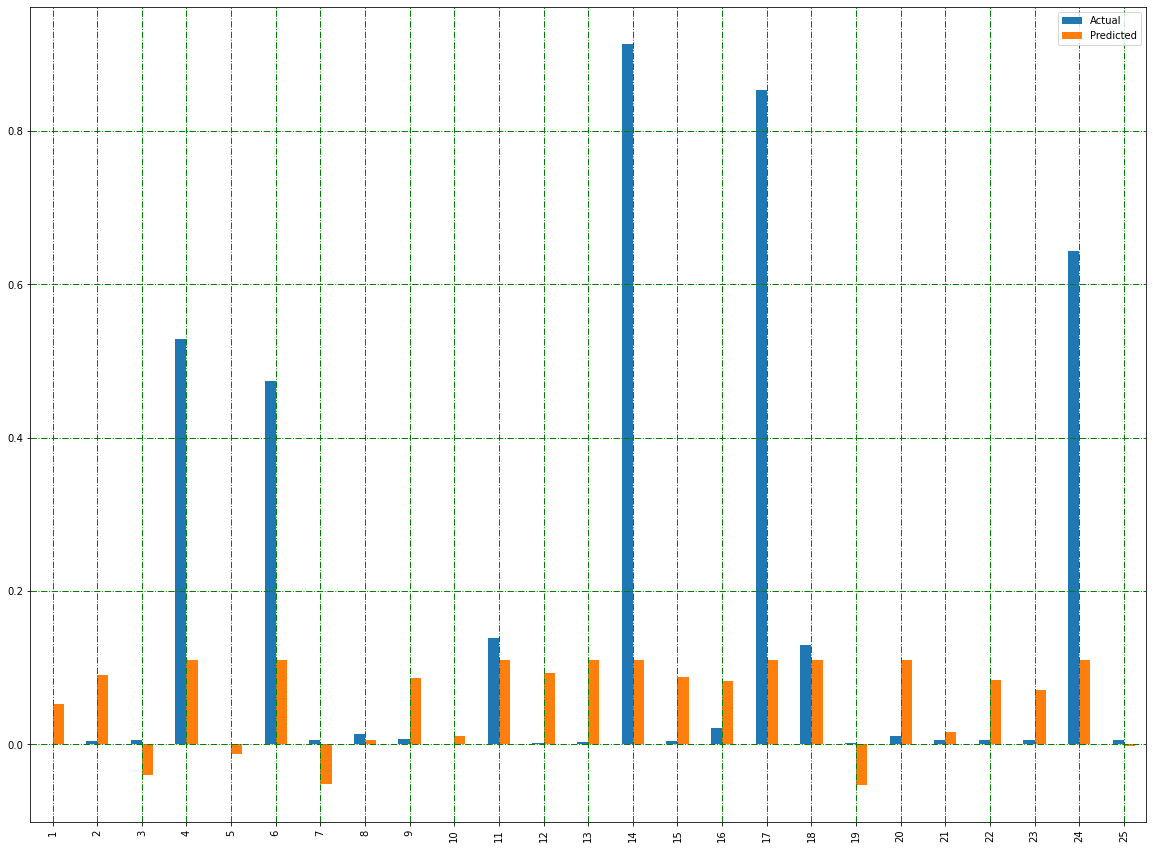

In [33]:
df1[:25].plot(kind='bar',figsize=(20,15))
plt.grid(which='major', linestyle='-.', linewidth='1', color='green')
plt.grid(which='minor', linestyle=':', linewidth='1', color='black')
plt.show()

## Linear Regression

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
model_LR = LinearRegression(normalize=True).fit(train_x, train_y)

In [36]:
pred_y_LR = model_LR.predict(test_x)
r_sq_LR = model_LR.score(test_x, test_y)

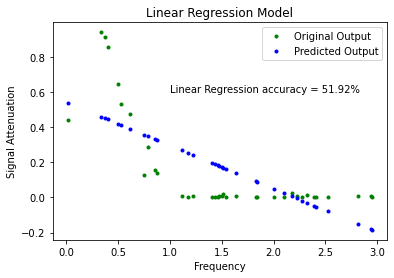

In [37]:
plt.plot(test_x, test_y, 'g.', label='Original Output' )
plt.plot(test_x, pred_y_LR, 'b.', label= "Predicted Output")
plt.text(1, 0.6, ("Linear Regression accuracy = {:0.2f}%".format(100 * r_sq_LR)))
plt.xlabel('Frequency')
plt.ylabel('Signal Attenuation')
plt.title('Linear Regression Model')
plt.legend()
plt.savefig('prediction_by_LR.png')

In [39]:
df2 = pd.DataFrame({"Actual": test_y.flatten(), 
                    "Predicted": pred_y_LR.flatten()},
                  index=range(1, len(test_y)+1))
df2.head()

,Actual,Predicted
1,0.000243,0.092376
2,0.004062,0.187869
3,0.005922,-0.150976
4,0.528822,0.412738
5,0.000325,-0.080127


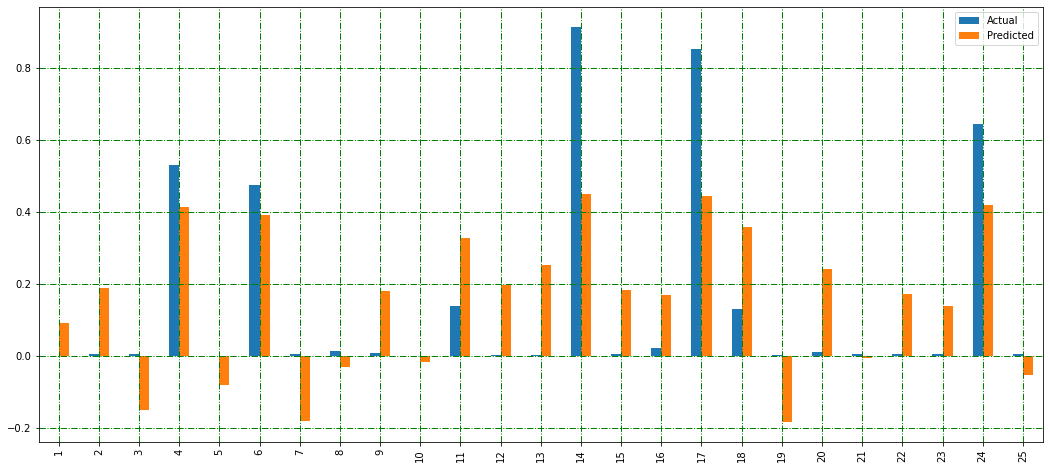

In [40]:
df2[:25].plot(kind='bar',figsize=(18,8))
plt.grid(which='major', linestyle='-.', linewidth='1', color='green')
plt.grid(which='minor', linestyle=':', linewidth='1', color='black')
plt.show()

## Decision Tree Regressor

In [41]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as mae

In [42]:
model_tree = DecisionTreeRegressor(random_state=0).fit(train_x, train_y)

In [43]:
pred_y_tree = model_tree.predict(test_x)
r_sq_tree = model_tree.score(test_x, test_y)
print("Accuracy: {:.2f}%".format(r_sq_tree*100))

Accuracy: 93.93%


In [44]:
def get_mae(max_leaf_nodes, train_x, train_y, test_x, test_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_x, train_y)
    preds_val = model.predict(test_x)
    maef = mae(test_y, preds_val)
    return(maef)

for leaf_nodes in range(2, 11):
    my_mae = get_mae(leaf_nodes, train_x, train_y, test_x, test_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(leaf_nodes, my_mae))

Max leaf nodes: 2  		 Mean Absolute Error:  0
Max leaf nodes: 3  		 Mean Absolute Error:  0
Max leaf nodes: 4  		 Mean Absolute Error:  0
Max leaf nodes: 5  		 Mean Absolute Error:  0
Max leaf nodes: 6  		 Mean Absolute Error:  0
Max leaf nodes: 7  		 Mean Absolute Error:  0
Max leaf nodes: 8  		 Mean Absolute Error:  0
Max leaf nodes: 9  		 Mean Absolute Error:  0
Max leaf nodes: 10  		 Mean Absolute Error:  0


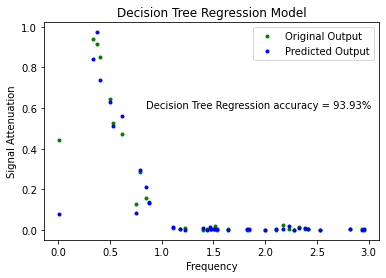

In [45]:
plt.plot(test_x, test_y, 'g.', label='Original Output' )
plt.plot(test_x, pred_y_tree, 'b.', label= "Predicted Output")
plt.text(0.85, 0.6, ("Decision Tree Regression accuracy = {:0.2f}%".format(100 * r_sq_tree)))
plt.xlabel('Frequency')
plt.ylabel('Signal Attenuation')
plt.title('Decision Tree Regression Model')
plt.legend()
plt.savefig('prediction_by_tree.png')

In [46]:
df3 = pd.DataFrame({"Actual": test_y.flatten(), 
                    "Predicted": pred_y_tree.flatten()},
                  index=range(1, len(test_y)+1))
df3.head()

,Actual,Predicted
1,0.000243,0.003879
2,0.004062,0.001523
3,0.005922,0.004395
4,0.528822,0.510407
5,0.000325,0.001531


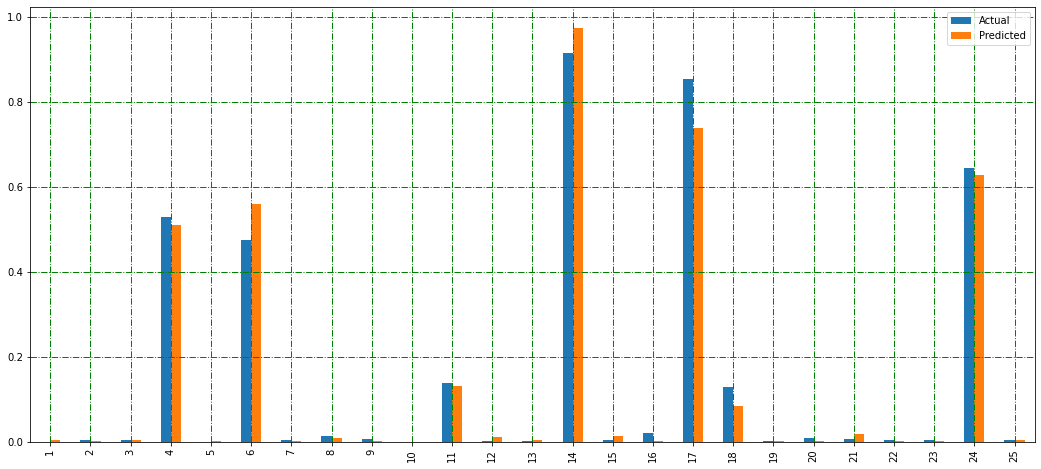

In [47]:
df3[:25].plot(kind='bar',figsize=(18,8))
plt.grid(which='major', linestyle='-.', linewidth='1', color='green')
plt.grid(which='minor', linestyle=':', linewidth='1', color='black')
plt.show()

## Random Forest Regressor

In [48]:
from sklearn.ensemble import RandomForestRegressor

In [49]:
model_RFR = RandomForestRegressor(random_state=1).fit(train_x, train_y)

In [50]:
pred_y_RFR = model_RFR.predict(test_x)
r_sq_RFR = model_RFR.score(test_x,test_y)
print("Accuracy: {:.2f}%".format(r_sq_RFR*100))

Accuracy: 95.22%


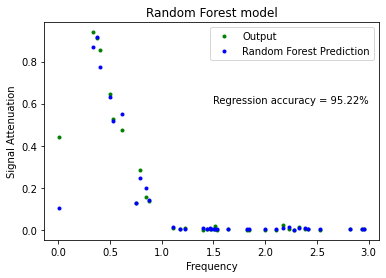

In [56]:
plt.plot(test_x, test_y, "g.", label='Output' )
plt.plot(test_x, pred_y_RFR, "b.", label= "Random Forest Prediction")
plt.text(1.5, .6, ("Regression accuracy = {:0.2f}%".format(100 * r_sq_RFR)))
plt.xlabel('Frequency')
plt.ylabel('Signal Attenuation')
plt.title('Random Forest model')
plt.legend()
plt.savefig('prediction_by_random_forest_algo.png')

In [53]:
df4 = pd.DataFrame({"Actual": test_y.flatten(), 
                    "Predicted": pred_y_RFR.flatten()},
                  index=range(1, len(test_y)+1))
df4.head()

,Actual,Predicted
1,0.000243,0.003766
2,0.004062,0.005283
3,0.005922,0.003509
4,0.528822,0.515840
5,0.000325,0.003535


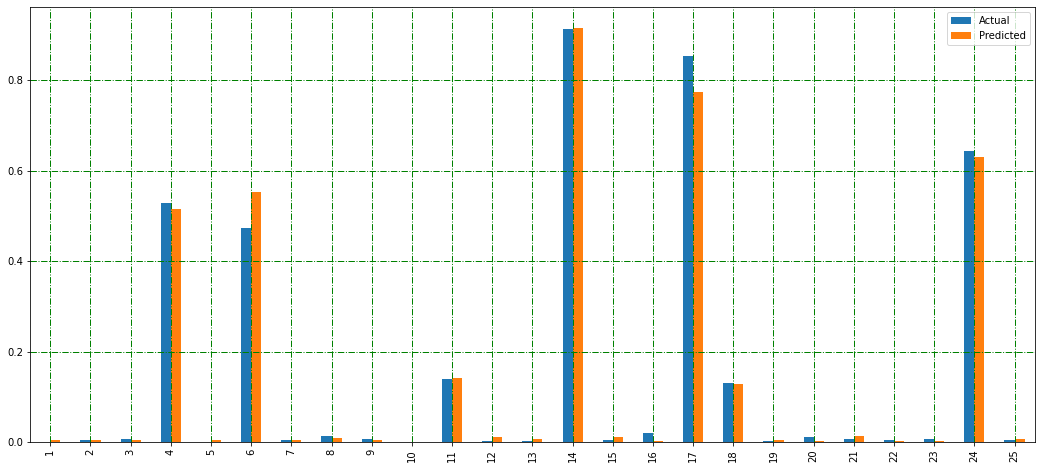

In [54]:
df4[:25].plot(kind='bar',figsize=(18,8))
plt.grid(which='major', linestyle='-.', linewidth='1', color='green')
plt.grid(which='minor', linestyle=':', linewidth='1', color='black')
plt.show()

## Analysis

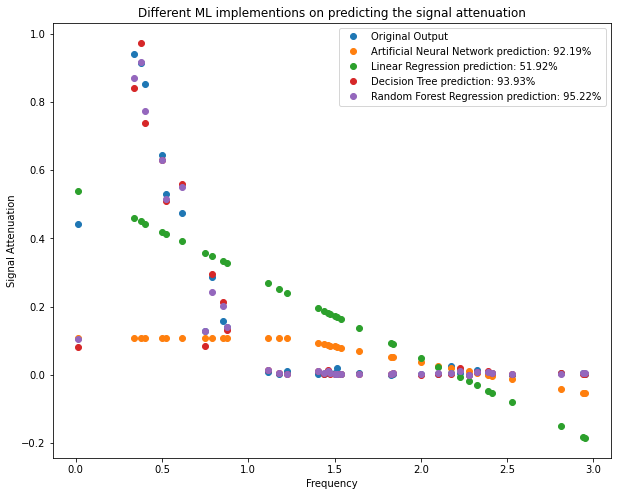

In [55]:
plt.figure(figsize=(10,8))
plt.plot(test_x, test_y, "o", label="Original Output")
plt.plot(test_x, pred_y_ANN, "o", label="Artificial Neural Network prediction: {:.2f}%".format(acc * 100))
plt.plot(test_x, pred_y_LR, "o", label="Linear Regression prediction: {:.2f}%".format(r_sq_LR * 100))
plt.plot(test_x, pred_y_tree, "o", label="Decision Tree prediction: {:.2f}%".format(r_sq_tree * 100))
plt.plot(test_x, pred_y_RFR, "o", label="Random Forest Regression prediction: {:.2f}%".format(r_sq_RFR * 100))
plt.xlabel("Frequency")
plt.ylabel("Signal Attenuation")
plt.title("Different ML implementions on predicting the signal attenuation")
plt.legend()
plt.savefig("analysis.png")
plt.show()